# Final Programming Assignment

My final project uses 4 datasets investigaing heart mortality (3 year mortality rate - age standarized i.e. "Data_Value") from 2014 to 2017. All 4 datasets come from the data.gov and look at heart mortality with a racial, gender, and state lens. Since each dataset has state information, I added the region and division that corresponds to each state. The "states" csv file (https://www.kaggle.com/omer2040/usa-states-to-region) matches the state with the region and divsion. Once all datasets are merged together, I created a few plots to explore heart mortality. 

## Part 1: Heart Disease Mortality 2014 (Json Url)

In part 1, I only focused on the 2014 dataset and import it as a json url https://chronicdata.cdc.gov/views/i2vk-mgdh/rows.json?accessType=DOWNLOAD. As I looped through the json file, I added region, division, and converted the Year and Data_Value to numeric values. I created a list of dictionaries and then converted this into a dataframe (heart1). 

In [1]:
import requests, json
import pandas as pd
import numpy as np
import seaborn as sns
import os

#import state csv - general state & region info
states = pd.read_csv('/home/jupyter-mmunozru/hds5210-2021/final/states.csv')
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [2]:
#import heart disease data.gov - mortality by race & state

def heart_json(url):
    """ (url) -> dataframe
    Takes json url from data.gov datasets concerning heart disease mortality, creates a dictionary, and then converts dictionary into a dataframe 
    (https://catalog.data.gov/dataset/heart-disease-mortality-data-among-us-adults-35-by-state-territory-and-county-2015-2017). The function also
    adds the Region & Division (taken from the State File) for each state that is in the json url. The json urls are set up the same way for the 
    heart mortality datasets. 
    """
    
    #request access to url
    r = requests.get(url) 
    heart_gov = r.json() #json.loads(r.text) - also works

    #get column names of json file
    headers=[]
    for col in heart_gov['meta']['view']['columns']:
        headers.append(col['name'])

    data = []
    
    #create dict with column names & data rows 
    for row in heart_gov['data']:
        #create key & value 
        data_dict = dict(zip(headers,row))
        data_dict['Year'] = int(data_dict['Year']) #convert str to num

        #convert Year & Data_Value str to float
        if data_dict['Data_Value'] is None:
            data_dict['Data_Value'] = np.NaN      
        else:
            data_dict['Data_Value'] = float(data_dict['Data_Value']) #convert str to num

        #Add Region & Division if state abbreviations match
        if states['State Code'].str.contains(row[9]).any():
            ind = states[states['State Code']==row[9]].index[0]
            data_dict.update({'Region':states['Region'][ind],'Division':states['Division'][ind]})
        else:
            data_dict.update({'Region':None,'Division':None})

        data.append(data_dict)
    
    df = pd.DataFrame(data)
        
    return df
    

In [3]:
link = 'https://chronicdata.cdc.gov/views/i2vk-mgdh/rows.json?accessType=DOWNLOAD'
df1 = heart_json(link)

In [4]:
#Keep interesting cols
heart1 = df1[['Year', 'LocationAbbr','Data_Value','Data_Value_Type', 'Stratification1','Stratification2','Region','Division']]
heart1 = heart1[(heart1['Stratification1']!='Overall') &
              (heart1['Stratification2']!='Overall')] 
heart1.head()

,Year,LocationAbbr,Data_Value,Data_Value_Type,Stratification1,Stratification2,Region,Division
101,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
102,2014,AK,317.5,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
103,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
104,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
105,2014,AK,400.7,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific


In [5]:
heart1.shape

(32820, 8)

## Part 2: Heart Disease Mortality by race & region 2015 - 2017 (csv files)

In part 2, the 2015, 2016, and 2017 dataset were imported as csv files https://catalog.data.gov/dataset/heart-disease-mortality-data-among-us-adults-35-by-state-territory-and-county-2015-2017. Since all three files have the same structure, I merged them into one dataframe (heart2). Then I added region and division as columns to the dataframe. 

In [6]:
def files(keyword):
    """ (str) -> list of filenames
    Searches for filenames that start with the provided string i.e. keyword in the local directory 
    and then creates a list with those desired filenames. 
    """
    path = os.getcwd()
    files = os.listdir(path)
    Keyword_files = [f for f in files if f.startswith(str(keyword))]
    
    return Keyword_files

In [7]:
heart_files = files('Heart_Disease_')
heart_files

['Heart_Disease_Mortality_2015.csv',
 'Heart_Disease_Mortality_2017.csv',
 'Heart_Disease_Mortality_2016.csv']

In [8]:
df2 = pd.concat((pd.read_csv(h) for h in heart_files))

In [9]:
df2['Year'].unique()

array([2015, 2017, 2016])

In [10]:
#Add Region & Divions if state abbreviations match
add_region = dict(zip(states['State Code'],states['Region']))
add_division = dict(zip(states['State Code'],states['Division']))

df2['Region'] = df2['LocationAbbr'].map(add_region)
df2['Division'] = df2['LocationAbbr'].map(add_division)                    

In [11]:
#Keep interesting cols
heart2 = df2[['Year', 'LocationAbbr','Data_Value','Data_Value_Type', 'Stratification1','Stratification2','Region','Division']]
heart2 = heart2[(heart2['Stratification1']!='Overall') &
              (heart2['Stratification2']!='Overall')] 
heart2.head()

,Year,LocationAbbr,Data_Value,Data_Value_Type,Stratification1,Stratification2,Region,Division
0,2015,CO,326.0,"Age-adjusted, 3-year Average Rate",Male,White,West,Mountain
1,2015,ME,247.0,"Age-adjusted, 3-year Average Rate",Male,Black,Northeast,New England
5,2015,US,516.3,"Age-adjusted, 3-year Average Rate",Male,Black,NaN,NaN
6,2015,US,331.0,"Age-adjusted, 3-year Average Rate",Female,Black,NaN,NaN
7,2015,US,284.3,"Age-adjusted, 3-year Average Rate",Male,Hispanic,NaN,NaN


In [12]:
heart2.shape

(89473, 8)

## Part 3: Combine heart1 & heart2 - Explore

Both heart1 & heart2 have the same structure and were merged to create one dataframe called heart. Basic statistics and visualizations were created to explore differences in heart mortality across year, gender, enthnicity, and region. 

In [13]:
heart = pd.concat([heart1,heart2])
heart.shape

(122293, 8)

In [14]:
heart.head()

,Year,LocationAbbr,Data_Value,Data_Value_Type,Stratification1,Stratification2,Region,Division
101,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
102,2014,AK,317.5,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
103,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
104,2014,AK,NaN,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific
105,2014,AK,400.7,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,White,West,Pacific


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae3f5db3c8>]],
      dtype=object)

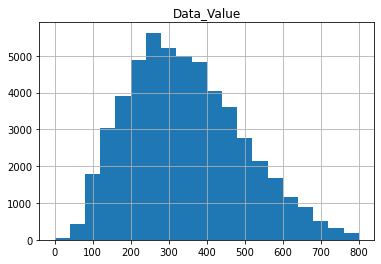

In [15]:
heart[['Data_Value']].hist(bins=20, range=[0,800])

In [16]:
round(heart['Data_Value'].mean(),2)

349.21

In [17]:
heart[heart['Data_Value']==heart['Data_Value'].max()]

,Year,LocationAbbr,Data_Value,Data_Value_Type,Stratification1,Stratification2,Region,Division
37165,2015,OH,5161.7,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,Black,Midwest,East North Central


In [18]:
heart[heart['Data_Value']==heart['Data_Value'].min()]

,Year,LocationAbbr,Data_Value,Data_Value_Type,Stratification1,Stratification2,Region,Division
50495,2015,TX,0.0,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Female,Hispanic,South,West South Central
14321,2017,IL,0.0,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Female,Asian and Pacific Islander,Midwest,East North Central
15948,2017,IN,0.0,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Male,Asian and Pacific Islander,Midwest,East North Central
15305,2016,IL,0.0,"Age-adjusted, Spatially Smoothed, 3-year Avera...",Female,Asian and Pacific Islander,Midwest,East North Central


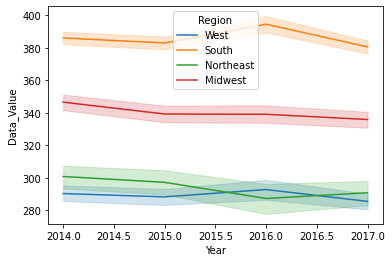

In [19]:
sns.lineplot(data=heart,x="Year",y="Data_Value",hue="Region")

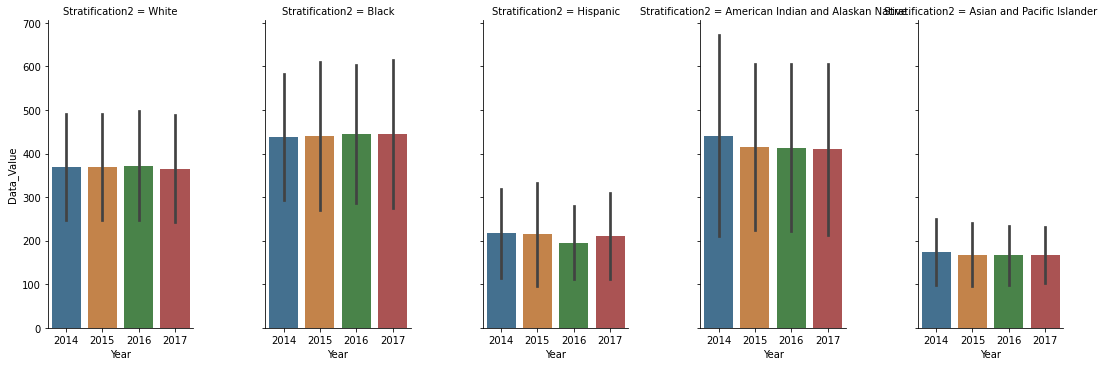

In [20]:
y = sns.catplot(x="Year", y="Data_Value", col="Stratification2",
                data=heart, saturation=.5,
                kind="bar", ci="sd", aspect=.6)

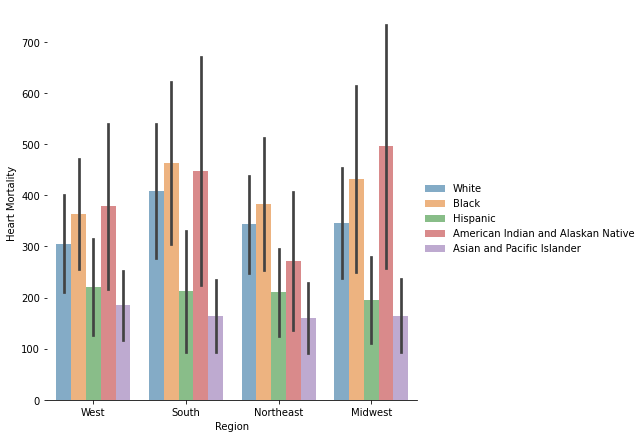

In [21]:
e = sns.catplot(
    data=heart, kind="bar",
    x="Region", y="Data_Value", hue="Stratification2",
    ci="sd", palette="tab10", alpha=.6, height=6
)
e.despine(left=True)
e.set_axis_labels("Region", "Heart Mortality")
e.legend.set_title("")

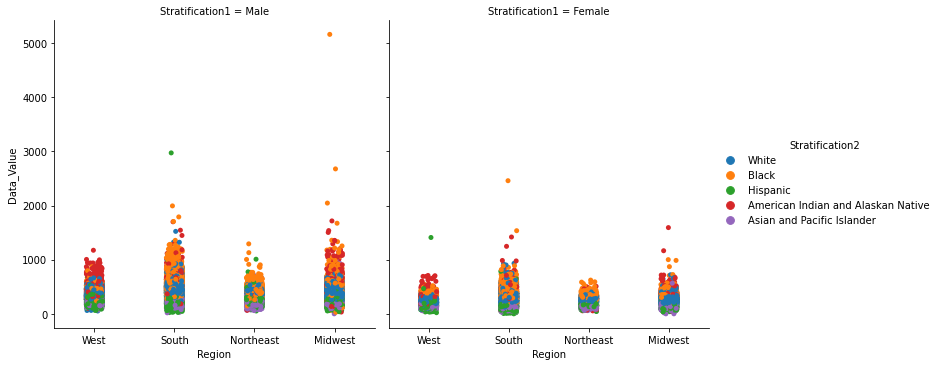

In [22]:
r = sns.catplot(x="Region",y="Data_Value",hue="Stratification2",col="Stratification1",data=heart)

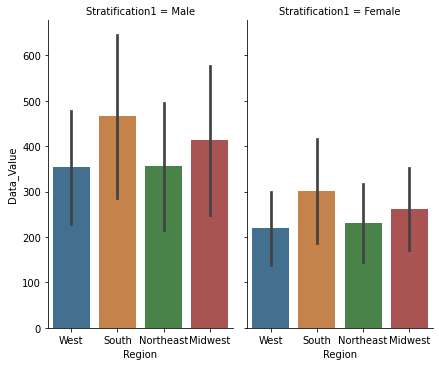

In [23]:
g = sns.catplot(x="Region", y="Data_Value", col="Stratification1",
                data=heart, saturation=.5,
                kind="bar", ci="sd", aspect=.6)

## Part 4: Conclusions

Heart disease mortality rate was consistent from 2014 to 2017 (fig. 2). Overall, the region with the largest heart disease mortality rate the South followed by Midwest. The Northeast and West regions had similar heart disease mortality rates. The ethnic groups at highest risk of heart failure from heart disease were Black, American Indian/Alaskan Native, and White, respectively (fig. 3).  

Looking at Region and Ethnicity, heart disease mortality rate for Black and White people were fairly consistent and the highest across all four regions (fig. 4). Asian and Pacific Islander people were consistent across all regions and had lower heart mortality rate. 

Gender seems to play a big part in heart disease mortality rates. Males have a higher heart disease mortality rate than females across all regions. Men is the South are at the highest risk (fig. 5 and fig. 6). 

Based on these conclusions, it is important to have public health intitatives in all four regions. The most important group to target would be Black males living in the South. The next step would be to investigate specific states and counties that may be driving these numbers in the South.   


---

---

---

## Submitting Your Work

In order to submit your work, you'll need to use the `git` command line program to **add** your homework file (this file) to your local repository, **commit** your changes to your local repository, and then **push** those changes up to github.com.  From there, I'll be able to **pull** the changes down and do my grading.  I'll provide some feedback, **commit** and **push** my comments back to you.  The first line of code below will **pull** down my comments into your local folders.

To run through everything one last time and submit your work:
1. Use the `Kernel` -> `Restart Kernel and Run All Cells` menu option to run everything from top to bottom and stop here.
2. Save this note with Ctrl-S (or Cmd-S)
2. Skip down to the last command cell (the one starting with `%%bash`) and run that cell.

If anything fails along the way with this submission part of the process, let me know.  I'll help you troubleshoort.

In [24]:
assert False, "DO NOT REMOVE THIS LINE"

AssertionError: DO NOT REMOVE THIS LINE

---

In [28]:
%%bash
git pull
git add final_assignment.ipynb
git add Heart_Disease_Mortality_2015.csv
git add Heart_Disease_Mortality_2016.csv
git add Heart_Disease_Mortality_2017.csv
git add states.csv
git commit -a -m "Submitting the final assignment"
git push

Already up to date.
[main 3c9d528] Submitting the final assignment
 4 files changed, 161610 insertions(+)
 create mode 100644 final/Heart_Disease_Mortality_2015.csv
 create mode 100644 final/Heart_Disease_Mortality_2016.csv
 create mode 100644 final/Heart_Disease_Mortality_2017.csv
 create mode 100644 final/states.csv


fatal: pathspec 'final_assignment.ipynb' did not match any files
To github.com:mmunozru/hds5210-2021.git
   4a9f26d..3c9d528  main -> main



---

If the message above says something like _Submitting the week 10 review exercises_ or _Everything is up to date_, then your work was submitted correctly.